# q-learning

We try out $q$-learning with two very simple MDPs.

In [1]:
import random 
import numpy as np

# in colab use
#!pip install gym
from gym import spaces

import matplotlib.pyplot as plt
plt.style.use("seaborn")

The q-learning algorithm.

In [2]:
# constant learning rate
def constant_rate_factory(learning_rate):
    return lambda i : learning_rate

# decaying learning rate
def power_rate_factory(eta0,decay):
    def learning_rate(i):
        return eta0/(1+i*decay)
    return learning_rate

class Q_Learner:
    def __init__(self,env,learning_rate,epsilon=0.5,iterations=1000,record_state=None):
        self.env=env
        self.epsilon=epsilon
        self.iterations=iterations
        ### this is just to watch the progress of the algorithm
        self.record_state=record_state
        self.record=[[] for _ in range(self.env.action_space.n)]
        ### go!
        self.run()

    # I don't know how many states there are, so we make room for new ones
    # that we encounter
    def lazy_init_q(self,state):
        if state not in self.q:
            self.q[state]=[0]*self.env.action_space.n # initialise values to 0
            
    # simple epsilon greedy exploration strategy
    def eps_greedy(self,state,i):
        self.lazy_init_q(state) # ensure that self.q has an entry for the current state
        if random.random()<=self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q[state])
    
    def run(self):
        self.q={}
        state=self.env.reset()
        for i in range(self.iterations):
            action=self.eps_greedy(state,i)
            new_state,reward,done,_=self.env.step(action)
            self.lazy_init_q(new_state) # ensure that self.q has an entry for new state
            new_max_q=max(self.q[new_state])
            eta=learning_rate(i)
            self.q[state][action]=(1-eta)*self.q[state][action] + eta*(reward+new_max_q)
            ### this is just to watch the progress of the algorithm
            if self.record_state is not None:
                if state==self.record_state:
                    self.record[action].append(self.q[state][action])
            state=new_state
            if done: # episode is over, start a new one
                state=self.env.reset()

    # convenience method to get policy based on q-values
    def policy(self):
        def best_policy(state):
            return np.argmax(self.q[state])
        return best_policy

# convenience method to plot evolution of q-values during progress of algorithm
def plot_record(records,title=""):
    _,ax=plt.subplots(figsize=(10,5))
    ax.plot(records[0],label="action 0")
    ax.plot(records[1],label='action 1')
    ax.set_xlabel("# of visit")
    ax.set_ylabel("q-value")
    ax.legend()
    ax.set_title(title)

## An extremely simple MDP

We first try q-learning with a single state MDP. That is, whatever action we take, the episode is over after the first action. 

The rewards are as follows: if action == state, we have a 2/3 chance of winning a reward of 1, otherwise we receive -1. If action != state, we lose (-1). It should be clear, what the best action is.

It's also clear what the true optimal $q$-values are:

* $q^*(0,0)=\frac{2}{3}\cdot 1+\frac{1}{3}\cdot(-1)=\frac{1}{3}$
* $q^*(0,1)=-1$
* $q^*(1,0)=-1$
* $q^*(1,1)=\frac{1}{3}$

The MDP I am going to implement will not inherit from the gym.Env class. Rather I will use [duck typing](https://en.wikipedia.org/wiki/Duck_typing) ("if it walks like a duck and quacks like a duck, it's a duck") to keep things simple. The only reference to the gym package that I'll be using is to introduce a variable <code>action_space</code> that receives two discrete actions. 

In [3]:
class Single_State_MDP:
    def __init__(self):
        self.action_space = spaces.Discrete(2)  # to make things compatible with gym
    def reset(self):
        self.state=random.randint(0,1)
        return self.state
    def step(self,action):
        if action!=self.state:
            return (42,-1,True,{})
        if random.random()<2/3:
            return (42,1,True,{})
        return (42,-1,True,{})
        
single_env=Single_State_MDP()
single_env.reset()

1

{0: [0.29326979071319204, -0.9784596519900856],
 42: [0, 0],
 1: [-0.9855661547517016, 0.3588043690881672]}

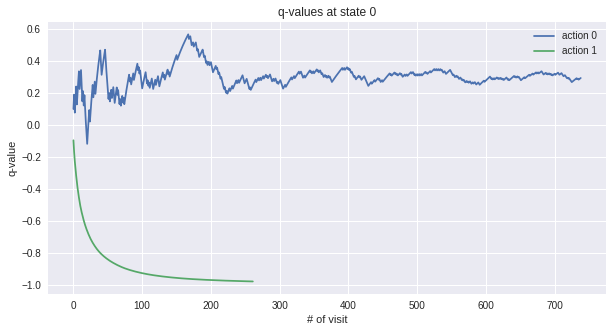

In [9]:
learning_rate=power_rate_factory(eta0=0.1,decay=0.01)
ql=Q_Learner(single_env,learning_rate=learning_rate,iterations=2000,record_state=0,epsilon=0.5)
plot_record(ql.record,title="q-values at state 0")
ql.q

What can we say about the $q$-values? Clearly, they are still converging. This is quite remarkable, as the MDP couldn't be simpler. Perhaps we could achieve better convergence with a different learning rate or a different $\epsilon$.

## A two state MDP

Now let's look at a two-state (or rather two states plus terminal state) MDP. We start in position 0. We can either move up or down, and with 90% probability the move succeeds. With 10% probability we do the opposite (move down instead of up, or the other way round). The state then increases or decreases depending on the move. State -1 is a terminal state and yields a reward of +1. State 2 is also a terminal state and yields +3. State 1 is not terminal and yields a penalty of -1. 

Obviously the best policy is to always move up. In expectation it will yield a total reward of close to 2. The second best policy is to move down, with a total reward of close to 1.

In [5]:
move_down=0
move_up=1
class Two_State_MDP:
    def __init__(self):
        self.action_space = spaces.Discrete(2)
    def reset(self):
        self.state=0
        return self.state
    def step(self,action):
        if random.random()<0.9:
            move=2*action-1
        else:
            move=1-2*action
        self.state=self.state+move
        if self.state==-1:
            return (42,1,True,{})
        if self.state==0:
            return (self.state,0,False,{})
        if self.state==1:
            return (self.state,-1,False,{})
        if self.state==2:
            return (42,3,True,{})
        
two_env=Two_State_MDP()
two_env.reset()  # let's see what we get

0

{0: [1.1147821488138054, 1.805694555244936],
 1: [1.9272169738253073, 2.922553709777631],
 42: [0, 0]}

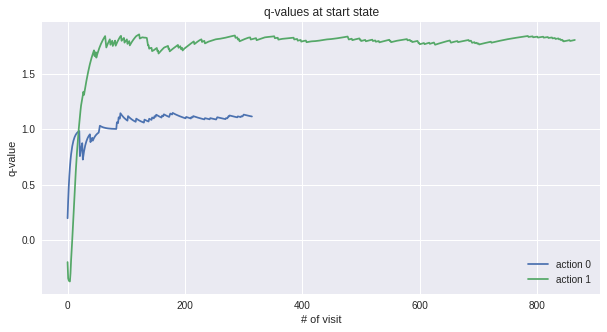

In [6]:
learning_rate=power_rate_factory(eta0=0.2,decay=0.01)

ql=Q_Learner(two_env,learning_rate=learning_rate,iterations=2000,record_state=0,epsilon=0.5)
plot_record(ql.record,title="q-values at start state")
ql.q

The $q$-values don't look too bad, and certainly indicate the right action. 

Try out $q$-learning for more complex MDPs -- I'll expect this to be challenging. I tried with the blackjack task in <code>gym</code> and failed.